[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/image-understanding-2022-2023/blob/main/practice2/practice2.ipynb)

# Practice 2: Content-based image retrieval

This is the second practice of image understanding in which we are going to code some of the things we have already seen during classes. 

**DO NOT MODIFY (ADD, DELETE,...) ANY CELL. YOU HAVE TO WRITE YOUR CODE ONLY IN THE CELLS SPECIFIED.**

Fill with your data:

- Full name 1: Nicolás Cossío Miravalles 

**Content-based image retrieval** (CBIR) is the mechanism of retrieving images relevant to a given query from a large collection of images known as an image database, based on their semantic or visual content rather than on derived attributes or keyword descriptors prescriptively defined for them.

As shown in the picture there are some basic steps involved in query and retrieval:

- Feature extraction: Of course, this part involves the extraction of image characteristics, such as texture, color, etc. It could also be considered a preprocessing step to, for example, resize or improve the quality of the images.
- Similarity measure: The similarity measurement is used to estimate the query image with the database images by similarity. The dissimilarity between the feature vector of the query image and the database images is calculated using different distance metrics. The higher the dissimilarity, the less similar the two images are. Some commonly used distances are: Euclidean distance, block distance, Minkowski distance and Mahalanobis distance.
- Retrieve the results: The N most similar images are displayed to the user.

![CBIR](https://raw.githubusercontent.com/upm-classes/image-understanding-2022-2023/main/practice2/figures/cbir_01.jpg "CBIR")

In [106]:
# Download data
# ! git clone https://github.com/upm-classes/image-understanding-2022-2023.git
# ! mv image-understanding-2022-2023/practice2/autoencoder_STL10_0499.pt .

In [107]:
# These are the libraries that should be used. 
# NO OTHER LIBRARIES ARE ALLOWED
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np


from scipy.signal import convolve2d
from sklearn.neighbors import KNeighborsClassifier

try:
    from torchinfo import summary
except:
    #! pip install torchinfo
    from torchinfo import summary

import warnings
warnings.filterwarnings("ignore")

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# assert device.type == "cuda", "You need to change the runtime type to GPU"


### Dataset

Labels of the CIFAR10 dataset. 

- Images are 96x96 pixels, color.
- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

In [109]:
LABELS = {
    0:'airplane', 
    1: 'bird',
    2: 'car',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'horse',
    7: 'monkey',
    8: 'ship',
    9: 'truck'
}

In [110]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = STL10(root='STL10/images', split='train', download=True, transform=train_transform)
test_data = STL10(root='STL10/images', split='test', download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


Visualizing the first 10 images of the train set

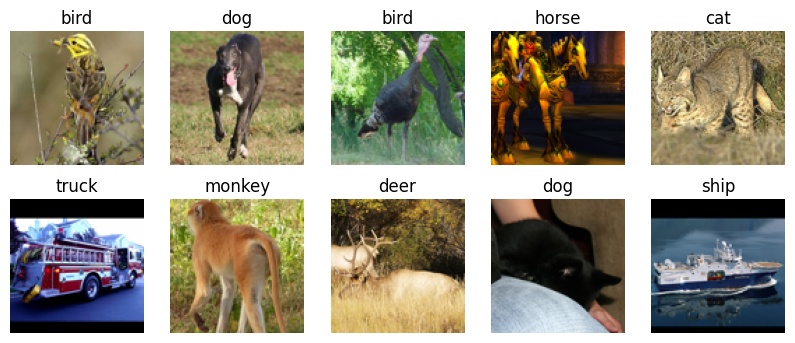

In [111]:
NUM_IMAGES = 10

fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(NUM_IMAGES):
    im = np.rollaxis(train_data[i][0].numpy(), 0, 3)
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(im)
    ax.set_title(LABELS[train_data[i][1]])
    ax.axis('off')
plt.show()

### Feature extraction phase with an autoencoder

An autoencoder is a neural network that is unsupervised which means that doesn't require any labeled data. 

They work by compressing the input into a latent space representation and reconstructing the output from this representation:

- Encoder: the part of the network that compresses the input into a latent space  representation (i.e., representation of compressed data). It can be represented by an encoding function \\( h=f(x) \\).
- Decoder: This part aims to reconstruct the input from the latent space representation. It can be represented by a decoding function \\( r=g(h) \\).

![CBIR Autoencoder](https://raw.githubusercontent.com/upm-classes/image-understanding-2022-2023/main/practice2/figures/cbir_02.jpg "CBIR Autoencoder")

In [112]:
# Autoencoder code

class Encoder(nn.Module):
    def __init__(self, num_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4608, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, num_channels):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 4608)
        self.conv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv5 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv6 = nn.Conv2d(256, num_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(x.size(0), 512, 3, 3)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        return x


class AutoEncoder(nn.Module):
    def __init__(self, num_channels, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(num_channels, latent_dim)
        self.decoder = Decoder(latent_dim, num_channels)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [113]:
# creating model
model = AutoEncoder(num_channels=3, latent_dim=128).to(device)

# Loading pretrained weights
model.load_state_dict(torch.load('autoencoder_STL10_0499.pt', 
                                 map_location=device))

summary(model, input_size=(1, 3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 3, 96, 96]            --
├─Encoder: 1-1                           [1, 128]                  --
│    └─Conv2d: 2-1                       [1, 64, 48, 48]           1,792
│    └─Conv2d: 2-2                       [1, 128, 24, 24]          73,856
│    └─Conv2d: 2-3                       [1, 128, 24, 24]          147,584
│    └─Conv2d: 2-4                       [1, 256, 12, 12]          295,168
│    └─Conv2d: 2-5                       [1, 256, 12, 12]          590,080
│    └─Conv2d: 2-6                       [1, 512, 6, 6]            1,180,160
│    └─Conv2d: 2-7                       [1, 512, 6, 6]            2,359,808
│    └─Conv2d: 2-8                       [1, 512, 3, 3]            2,359,808
│    └─Conv2d: 2-9                       [1, 512, 3, 3]            2,359,808
│    └─Linear: 2-10                      [1, 128]                  589,952
├─Decoder: 1-2                

Test how the autoencoder works with N random images

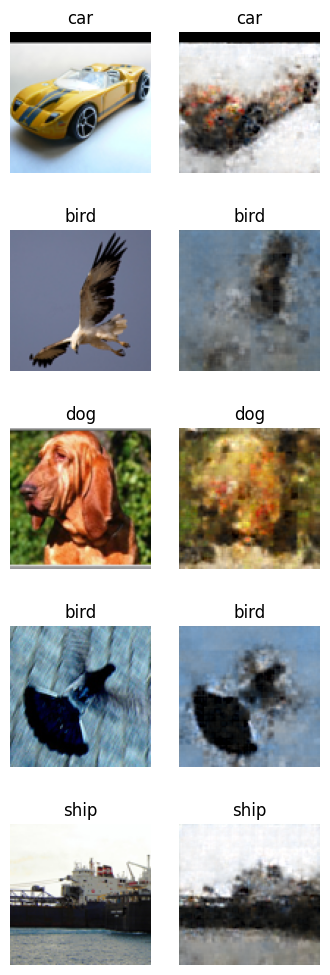

In [114]:
num_images = 5
idx_random = np.random.choice(len(train_data), num_images)

y_hat = np.array([model(torch.unsqueeze(train_data[i][0].to(device),
                                        0)).detach().cpu().numpy() 
                                        for i in idx_random])

fig = plt.figure(figsize=(4, num_images*3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_images):
    im1 = np.rollaxis(train_data[idx_random[i]][0].numpy(), 0, 3)
    im1 = np.clip(im1, 0, 1)
    ax1 = fig.add_subplot(6, 2, i * 2 + 1)
    ax1.imshow(im1)
    ax1.set_title(LABELS[train_data[idx_random[i]][1]])
    ax1.axis('off')
    im2 = np.rollaxis(np.squeeze(y_hat[i]), 0, 3)
    im2 = np.clip(im2, 0, 1)
    ax2 = fig.add_subplot(6, 2, i * 2 + 2)
    ax2.imshow(im2)
    ax2.set_title(LABELS[train_data[idx_random[i]][1]])
    ax2.axis('off')
plt.show()

#### Similarity calculation

This step involves calculating the similarity between all the images of the database and a test image.

As you can imagine this is high-demanding process (calculating all the distances), so there are different techniques that can be used to streamlite this process, such as precalculating the distances, use of distances trees.

As our database is not big, we are going to use for calculating the distance an algorithm called "k-nearest neighbors" (k-NN). k-NN is a non-parametric supervised learning method used for classification that determines the class/label of a new sample by taking into account the k closest training examples in a dataset. When k is set to one (k = 1), then input sample is assigned to the single nearest neighbor.

In our case, we are going to use the distances calculated for k-NN algorithm to retrieve the N most similar images.

In [116]:
# It takes some time to calculate the features for the train and testing sets

def extract_features(partition:str) -> np.array:
    # Here we use the encoder to return the latent features of the input images
    if partition == 'train':
        feats = np.array([model.encoder(torch.unsqueeze(train_data[i][0].to(device),
                                        0)).detach().cpu().numpy() 
                                        for i in range(len(train_data))])
    elif partition == 'test':
        feats = np.array([model.encoder(torch.unsqueeze(test_data[i][0].to(device),
                                        0)).detach().cpu().numpy() 
                                        for i in range(len(train_data))])
    return np.squeeze(feats)

train_feats = extract_features('train') # Train set
test_feats = extract_features('test') # Test set

print(f'Size train: {train_feats.shape}')
print(f'Size test: {test_feats.shape}')

KeyboardInterrupt: 

##### Task 1: Implement euclidean distance (1 point)
To measure the similarity between images, the euclidean distance between images x and y is commonly used. 
The closer to 0 the more similar x and y are.

In [117]:
def euclidean_distance(x: np.array, y: np.array) -> float:
    """Computes the euclidean distance between two vectors x and y.
    
    Args:
        x: A numpy array.
        y: A numpy array.
    Returns:
        The euclidean distance between x and y.
    """
    return np.sqrt(np.sum(np.square(x - y)))


In [118]:
assert np.isclose(euclidean_distance(np.array((5, 6, 1)), np.array((1, 1, 1))), 6.4031).all()
assert np.isclose(euclidean_distance(np.array((1, 1, 1)), np.array((1, 1, 1))), 0.0).all()

##### Retrieve the most similar images

In [119]:
IDX_SAMPLE = 500 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)    

# This function retreive the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats, np.zeros((train_feats.shape[0], 1)))
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

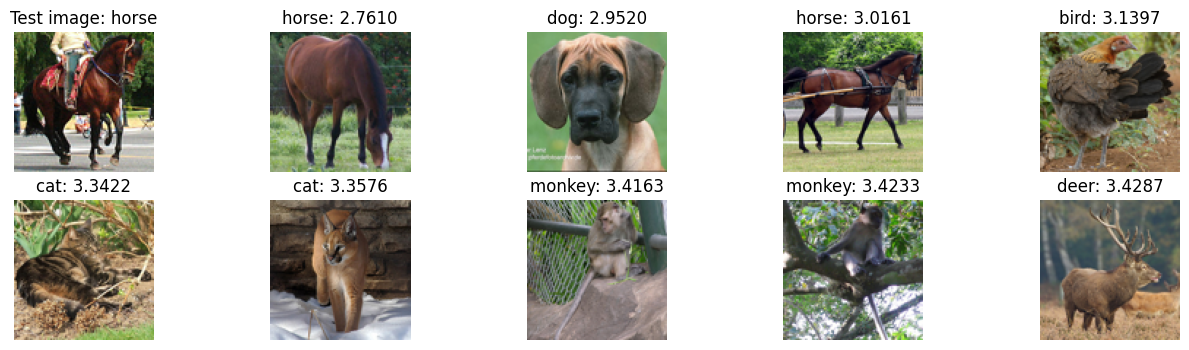

In [120]:
# Visualization of the images
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 5, 1)

ax.imshow(np.rollaxis(test_data[IDX_SAMPLE][0].numpy(), 0, 3))
ax.set_title(f'Test image: {LABELS[test_data[IDX_SAMPLE][1]]}')
ax.axis('off')
for i in range(NUM_SAMPLES):
    im = np.rollaxis(train_data[np.squeeze(retrieved_idx)[i]][0].numpy(), 0, 3)
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(im)
    label = LABELS[train_data[np.squeeze(retrieved_idx)[i]][1]]
    distance = np.squeeze(retrieved_distances)[i]
    title = f'{label}: {distance:.4f}'
    ax.set_title(title)
    ax.axis('off')
plt.show()

##### Task 2: Implement cosine distance (1 point)
Instead of the Euclidean distance, implement a distance based on the Cosine Similarity (CS). CS is a measurement that quantifies the similarity between two or more vectors. CS is the cosine of the angle between vectors. The vectors are typically non-zero and are within an inner product space. And it is defined as follows:
 
 $$ 
 d(x,y)=\frac{x \bullet y}{ ||x|| ||y||} 
 $$
 
where $\bullet$ represents the dot product, and $||.||$, the norm 2.
 
A cosine value of 0 means that the two vectors are at 90 degrees to each other (orthogonal) and have no match. The closer the cosine value to 1, the smaller the angle and the greater the match between vectors. 

In [121]:
# Hint: closer images to the sample should have a smaller distance

def cosine_distance(x:np.array, y:np.array) -> float:
    """Compute the cosine distance between two vectors.
    Args:
        x: A numpy array containing the first vector.
        y: A numpy array containing the second vector.
    Returns:
        The cosine distance between the two vectors.
    """
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)
    return 1 - np.dot(x, y) / (x_norm * y_norm)
 

In [122]:
assert np.isclose(cosine_distance(np.array((1, 0, 0)), np.array((1, 1, 1))), 0.42264, rtol=1e-03, atol=1e-05).all()
assert np.isclose(cosine_distance(np.array((1, 1, 1)), np.array((1, 1, 1))), 0.0).all()


In [123]:
IDX_SAMPLE = 500 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)    

# This function retreive the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats, np.zeros((train_feats.shape[0], 1)))
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

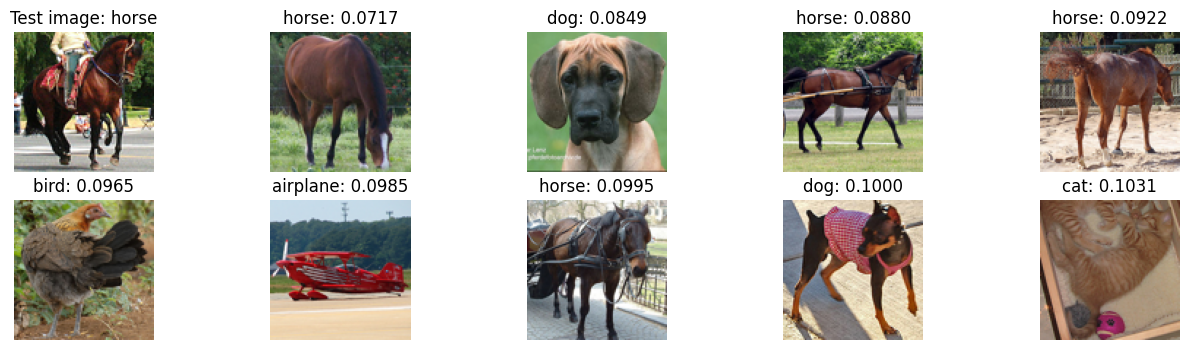

In [124]:
# Visualization of the images
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 5, 1)

ax.imshow(np.rollaxis(test_data[IDX_SAMPLE][0].numpy(), 0, 3))
ax.set_title(f'Test image: {LABELS[test_data[IDX_SAMPLE][1]]}')
ax.axis('off')
for i in range(NUM_SAMPLES):
    im = np.rollaxis(train_data[np.squeeze(retrieved_idx)[i]][0].numpy(), 0, 3)
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(im)
    label = LABELS[train_data[np.squeeze(retrieved_idx)[i]][1]]
    distance = np.squeeze(retrieved_distances)[i]
    title = f'{label}: {distance:.4f}'
    ax.set_title(title)
    ax.axis('off')
plt.show()

### Using raw pixels as features

Another type of features that we can use are the pixels of the image. For this with need to convert each image into a vector. 

##### Task 3: Implement a funtion to convert all images into a matrix (1 point). 
Hint: the shape of the output should be: [N, 96x96x3], where N is the number of images. 

In [125]:
def extract_features_raw(images:np.array) -> np.array:
    """Extract the features from a set of images.
    Args:
        images: A numpy array containing the images.
    Returns:
        A numpy array containing the features.
    """
    # Reshape the images into a matrix
    features = images.reshape(images.shape[0], -1)

    return features
    

In [126]:
train_images = np.array([train_data[i][0].detach().cpu().numpy() for i in range(len(train_data))])
train_images = np.rollaxis(train_images, 1, 4)
test_images = np.array([test_data[i][0].detach().cpu().numpy() for i in range(len(train_data))])
test_images = np.rollaxis(test_images, 1, 4)

train_feats_raw = extract_features_raw(train_images) # Train set
test_feats_raw = extract_features_raw(test_images) # Test set

In [127]:
assert (train_feats_raw.shape == np.array([5000, 96 * 96 * 3])).all()
assert (test_feats_raw.shape == np.array([5000, 96 * 96 * 3])).all()

x = np.reshape(np.array([range(27648)]), (1, 96, 96, 3))
assert extract_features_raw(x)[0][1] == 1
assert extract_features_raw(x)[0][9218] == 9218
assert extract_features_raw(x)[0][18432] == 18432


Show the results with raw pixels using the euclidean distance

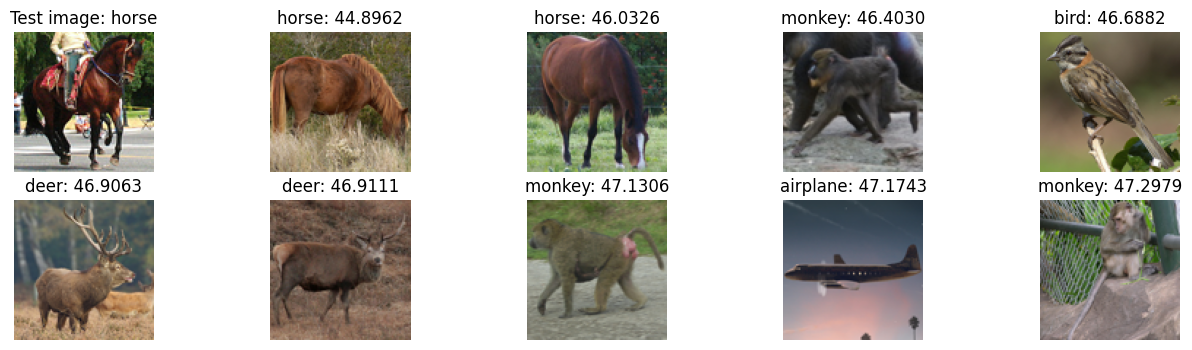

In [128]:
IDX_SAMPLE = 500 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats_raw[IDX_SAMPLE].reshape(1, -1)    

# This function retreive the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats_raw, np.zeros((train_feats_raw.shape[0], 1)))
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

# Visualization of the images
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 5, 1)

ax.imshow(np.rollaxis(test_data[IDX_SAMPLE][0].numpy(), 0, 3))
ax.set_title(f'Test image: {LABELS[test_data[IDX_SAMPLE][1]]}')
ax.axis('off')
for i in range(NUM_SAMPLES):
    im = np.rollaxis(train_data[np.squeeze(retrieved_idx)[i]][0].numpy(), 0, 3)
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(im)
    label = LABELS[train_data[np.squeeze(retrieved_idx)[i]][1]]
    distance = np.squeeze(retrieved_distances)[i]
    title = f'{label}: {distance:.4f}'
    ax.set_title(title)
    ax.axis('off')
plt.show()

Show the results with raw pixels using the cosine distance

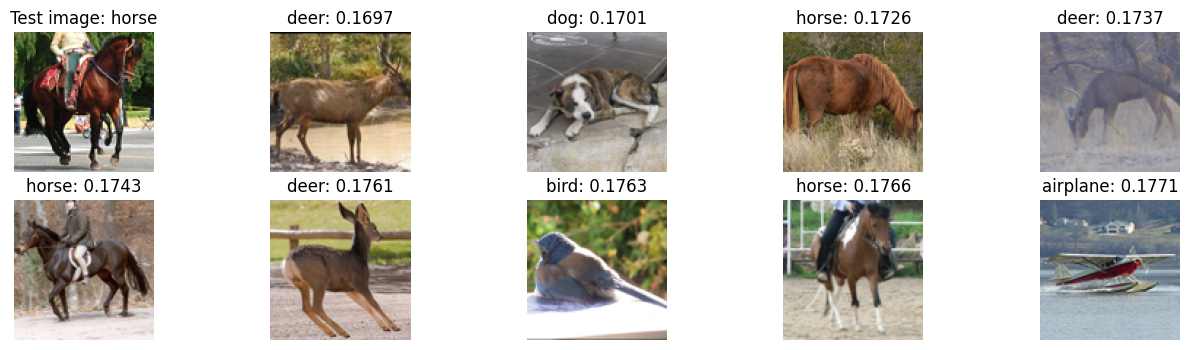

In [129]:
IDX_SAMPLE = 500 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats_raw[IDX_SAMPLE].reshape(1, -1)    

# This function retreive the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats_raw, np.zeros((train_feats_raw.shape[0], 1)))
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

# Visualization of the images
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 5, 1)

ax.imshow(np.rollaxis(test_data[IDX_SAMPLE][0].numpy(), 0, 3))
ax.set_title(f'Test image: {LABELS[test_data[IDX_SAMPLE][1]]}')
ax.axis('off')
for i in range(NUM_SAMPLES):
    im = np.rollaxis(train_data[np.squeeze(retrieved_idx)[i]][0].numpy(), 0, 3)
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(im)
    label = LABELS[train_data[np.squeeze(retrieved_idx)[i]][1]]
    distance = np.squeeze(retrieved_distances)[i]
    title = f'{label}: {distance:.4f}'
    ax.set_title(title)
    ax.axis('off')
plt.show()

#### Using features extracted by filtering

Usin the soble function implemented in the previous practice we are going to extract the features of the images. 

##### Task 4: Implement a funtion to extract the features of the a set of images (3 points).
Steps:
1. Convert each image into a grayscale version by calculating the average among channels.
2. From each grayscale image apply the sobel filtering.
3. Convert each filtered image into a vector.

Hint: the shape of the output should be: [N, 96x96x1], where N is the number of images.

In [130]:
def convolve(image: np.array, kernel: np.array) -> np.array:
    """
    Funtion to convolve a grayscale image given a kernel.
    """
    im = image.astype(np.float32)
    result = convolve2d(im, kernel, boundary='symm', mode='same')
    return result

def sobel_filtering(image: np.array) -> np.array:
    """
    Define the function using the filters sobel_x and sobel_y using function "convolve" 
    defined before. The input is an grayscale image of 8-bits. The output is a gradient
    image calcluated using sobel operators both x and y.
    """
    # Define sobel filters
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Convolve the image with the sobel filters as kernels
    grad_x = convolve(image, sobel_x)
    grad_y = convolve(image, sobel_y)

    # Calculate gradient magnitude and direction
    grad_mag = np.sqrt(grad_x * grad_x + grad_y * grad_y)
    # grad_dir = np.arctan2(grad_y, grad_x)

    return grad_mag



def extract_features_sobel(images:np.array) -> np.array:
    # Using features extracted by filtering
    """
     Args:
        images: A numpy array containing the images.
    
    Returns:
        A numpy array containing the features.
    
    """
    # Convert each image into a grayscale version by calculating the average among channels
    gray_images = np.mean(images, axis=-1)

    # From each grayscale image apply the sobel filtering
    filtered_images = []

    for i in range(gray_images.shape[0]):
        filtered_image = sobel_filtering(gray_images[i])
        filtered_images.append(filtered_image)

    filtered_images = np.array(filtered_images)

    # Convert each filtered image into a vector
    features = filtered_images.reshape(filtered_images.shape[0], -1)

    # Return features
    return features


In [131]:
train_feats_sobel = extract_features_sobel(train_images) # Train set
test_feats_sobel = extract_features_sobel(test_images) # Test set

In [132]:
assert (train_feats_sobel.shape == np.array([5000, 96*96])).all()
assert (test_feats_sobel.shape == np.array([5000, 96*96])).all()
assert (np.isclose(train_feats_sobel[1, 1:9], np.array([0.08000583, 0.30175989, 0.19362304, 0.20109494, 0.25172131, 0.0282184 , 0.2295969 , 0.13676229]))).all()
assert (np.isclose(test_feats_sobel[1, 1:9], np.array([0.26003544, 0.0942809 , 0.05918552, 0.11209864, 0.08725918, 0.08308626, 0.14767192, 0.073992]))).all()

Show the results with raw pixels using the euclidean distance

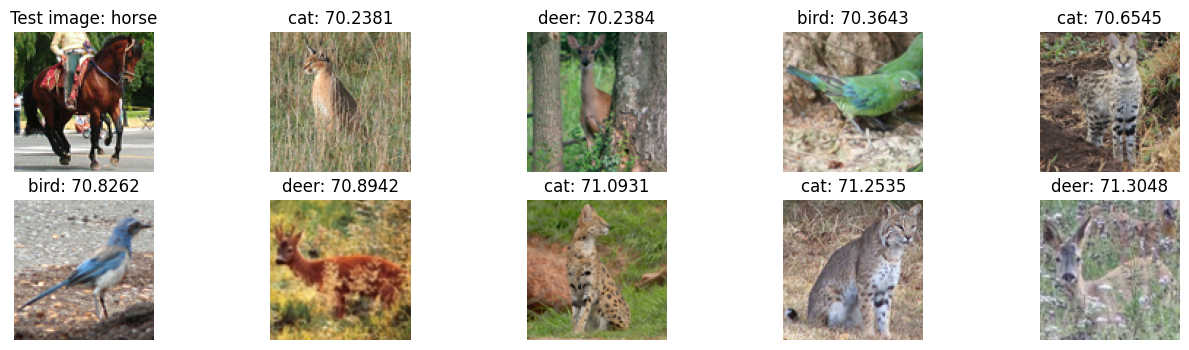

In [133]:
IDX_SAMPLE = 500 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats_sobel[IDX_SAMPLE].reshape(1, -1)    

# This function retreive the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats_sobel, np.zeros((train_feats_sobel.shape[0], 1)))
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

# Visualization of the images
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 5, 1)

ax.imshow(np.rollaxis(test_data[IDX_SAMPLE][0].numpy(), 0, 3))
ax.set_title(f'Test image: {LABELS[test_data[IDX_SAMPLE][1]]}')
ax.axis('off')
for i in range(NUM_SAMPLES):
    im = np.rollaxis(train_data[np.squeeze(retrieved_idx)[i]][0].numpy(), 0, 3)
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(im)
    label = LABELS[train_data[np.squeeze(retrieved_idx)[i]][1]]
    distance = np.squeeze(retrieved_distances)[i]
    title = f'{label}: {distance:.4f}'
    ax.set_title(title)
    ax.axis('off')
plt.show()

Show the results with raw pixels using the cosine distance

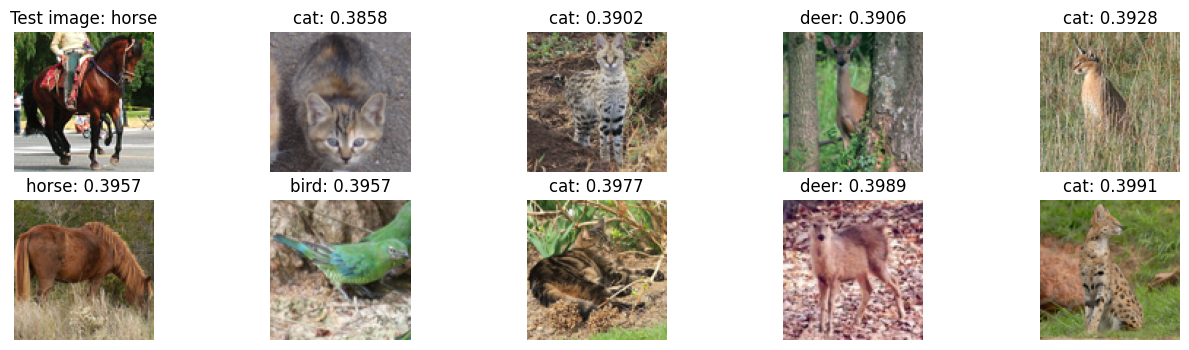

In [134]:
IDX_SAMPLE = 500 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats_sobel[IDX_SAMPLE].reshape(1, -1)    

# This function retreive the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats_sobel, np.zeros((train_feats_sobel.shape[0], 1)))
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

# Visualization of the images
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 5, 1)

ax.imshow(np.rollaxis(test_data[IDX_SAMPLE][0].numpy(), 0, 3))
ax.set_title(f'Test image: {LABELS[test_data[IDX_SAMPLE][1]]}')
ax.axis('off')
for i in range(NUM_SAMPLES):
    im = np.rollaxis(train_data[np.squeeze(retrieved_idx)[i]][0].numpy(), 0, 3)
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(im)
    label = LABELS[train_data[np.squeeze(retrieved_idx)[i]][1]]
    distance = np.squeeze(retrieved_distances)[i]
    title = f'{label}: {distance:.4f}'
    ax.set_title(title)
    ax.axis('off')
plt.show()

##### Task 5: Answer the following questions (4 points):

1. What considerations did you have when implementing the distance function based on cosine similarity?

We are given the cosine similarity function, which calculates the cosine of the angle between two vectors. The smaller the angle the greater the match between vectors, since we are looking for a distance function that is the inverse of the cosine similarity function, the cosine similarity function can be defined as:
 
 $$ 
 d(x,y)=1 - \frac{x \bullet y}{ ||x|| ||y||} 
 $$

 Which can be understood as the difference between 1 and the cosine similarity function. The smaller the angle between the vectors the greater the match between vectors, hence the smaller the distance between the vectors.

2. What differences do you find between the different experiments performed? Discuss the results obtained in terms of how they are affected by the characteristics extracted and the distances used.

I found that in general, the experiments showed that using more complex feature extraction methods, such as Sobel filtering, can improve the accuracy of CBIR compared to using raw pixel values. This is because these methods take into account the spatial relationships between pixels and can capture more complex features such as texture and shape.
The distance metric used also had a significant impact on the accuracy of the results. The Euclidean distance metric was sensitive to differences in pixel values, which can be influenced by noise or lighting conditions. On the other hand, the cosine distance metric was more robust to such variations and was better at capturing similarities between images based on their underlying structure.

Overall, the results of our experiments highlight the importance of carefully choosing feature extraction methods and distance metrics when designing image understanding systems. The choice of method can greatly impact the accuracy of the results and should be selected based on the specific needs and goals of the application.